# <center>Часть 4. Прогнозирование временных рядов на карте

## Введение
В части 3 мы прогнозировали временной ряд со сложной сезонностью с помощью модели **ARIMA** на примере одной из географических зон. В части 4 мы построим такие прогнозы для каждой зоны. Чтобы не подбирать вручную огромное количество моделей, нам понадобится сделать кластеризацию рядов.

## Вводные положения
Процесс подбора модели ARIMA в Питоне достаточно трудоёмок, поэтому вы не сможете вручную подобрать модель для каждого из рядов в выбранных ячейках. Чтобы облегчить ручной перебор, вам предстоит кластеризовать временные ряды и подобрать гиперпараметры модели ARIMA только один раз для всех рядов каждого кластера.

Результатом этой недели будут построенные с помощью ARIMA почасовые прогнозы количества поездок для всех географических зон Нью-Йорка. Модель, которую мы строим, должна делать почасовые прогнозы для всех выбранных непустых ячеек на 6 часов вперёд. Качество модели мы будем оценивать с помощью среднего абсолютного отклонения от истинного количества поездок в июне:

$$Q_{june}=\frac{1}{R∗715∗6}\sum_{r=1}^{R}\sum_{T=2016.05.31\ 23:00}^{2016.06.30\ 17:00}\sum_{i=1}^{6}∣\hat{y}^r_{T|T+i}−y^r_{T+i}∣,  $$   
    
$R$ — количество прогнозируемых рядов, $715$ — количество перебираемых концов истории.

Это демонстрационный проект. Построенные прогнозы предстоит загрузить на $kaggle$. К сожалению, в формате $kaggle$ сложно организовать конкурс по прогнозированию временных рядов в традиционном виде, с отложенным тестом и пересчётом лидерборда, поскольку прогнозы необходимо строить со скользящим концом истории. Здесь цель в том, чтобы посмотреть, какие модели, решения и признаки были использованы в аналогичных проектах, и понять, какие из них стоит попробовать и здесь.

## План

1. Составим из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмем только те, которые были отобраны на второй части). Не будем использовать данные за последние имеющиеся месяцы — май и июнь 2016!
2. Перед проведением кластеризации стандартизуем столбцы (вычтем выборочное среднее и поделим на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.
3. Кластеризуем географические зоны по значениям стандартизованных рядов. Подберем число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Построим графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.
4. В каждом кластере выберем наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера).
5. Для выбранных географических зон подберем на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров **p,d,q,P,D,Q** — так, как это делалось в прошлой части. Не будем использовать данные за последний имеющийся месяц — май и июнь 2016!
6. Для каждой из R географических зон настроим на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 построим прогноз на 6 часов вперёд и посчитаем в ноутбуке ошибку прогноза по следующему функционалу:
$$Q_{may}=\frac{1}{R∗739∗6}\sum_{r=1}^{R}\sum_{T=2016.04.30\ 23:00}^{2016.05.31\ 17:00}\sum_{i=1}^{6}∣\hat{y}^r_{T|T+i}−y^r_{T+i}∣.  $$ 

7. Для каждой из $R$ географических зон настроим на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 построим прогноз на 6 часов вперёд и запишем все прогнозы в файл в формате $id,y$, где столбец $id$ состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец $y$ — наш прогноз.
8. Загрузим полученный файл на $kaggle$: https://inclass.kaggle.com/c/yellowtaxi. Добавим в ноутбук ссылку на сабмишн.

## Выполнение

In [19]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpa0ak2vb8/pubring.gpg' created
gpg: /tmp/tmpa0ak2vb8/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [2]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 5.4MB/s 


In [0]:
import pandas as pd
import numpy as np
import os
from glob import glob
from datetime import datetime
from pandas.tseries.offsets import Day
from dateutil.relativedelta import relativedelta
# from datetime import timedelta
import pickle

# from tqdm import tqdm_notebook
from tqdm import tqdm
# tqdm_notebook().pandas()

from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

from numpy.linalg import LinAlgError

from itertools import product
import warnings

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
from sklearn import cluster
from matplotlib import cm
from math import ceil

In [0]:
import random

In [0]:
# path_to_data = 'C:\\Users\dsher\Documents\BIGDATA\sales_prediction_(yellow_taxi)'
path_to_data = 'drive/Colab Notebooks/mipt_ya_COURSERA/sales_prediction_(yellow_taxi)/data'

### 1. Подготовка данных
Составим из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмем только те, которые были отобраны на второй части). Не будем использовать данные за последние имеющиеся месяцы — май и июнь 2016!

подготовим список отобранных ячеек

In [0]:
# функция для загрузки агрегированных данных
def read_aggdata(file_name):
    return pd.read_csv(os.path.join(path_to_data, file_name), index_col=0, parse_dates=True)

In [24]:
aggdata = read_aggdata('aggdata_2016-05.csv')
regions = pd.read_csv(os.path.join(path_to_data, 'regions.csv'), sep=';')
regions['rate'] = aggdata.sum().values
regions['avr_hour_rate'] = regions['rate'] /31 /24
selected_cells = regions[regions['avr_hour_rate'] >= 5].region.values.astype(str).tolist()
print('Для контроля:\n', 
      len(selected_cells), selected_cells[0])

Для контроля:
 102 1075


Составляем датасет из нескольких месяцев (исключая май и июнь 2016):

In [17]:
data = pd.DataFrame()
for path_to_file in tqdm(glob(os.path.join(path_to_data, 'aggdata_*.csv'))):
    if os.path.basename(path_to_file) in ['aggdata_2016-05.csv', 'aggdata_2016-06.csv']:
        continue
    aggdata = read_aggdata(os.path.basename(path_to_file))
    data = pd.concat([data, aggdata[selected_cells]])

100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


In [18]:
data.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,80,144,50,77,319,402,531,617,846,267,...,12,0,2,44,5,41,4,70,7,66
2016-01-01 01:00:00,91,211,49,134,404,420,370,453,594,224,...,29,0,5,2,2,4,0,47,1,29
2016-01-01 02:00:00,90,146,23,110,393,425,313,366,377,138,...,47,0,3,0,4,0,0,69,1,14
2016-01-01 03:00:00,32,87,16,62,252,399,324,309,327,166,...,46,0,2,4,5,1,0,21,0,9
2016-01-01 04:00:00,24,43,10,53,145,254,264,333,318,145,...,43,0,0,1,1,0,0,26,1,6


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2904 entries, 2016-01-01 00:00:00 to 2016-04-30 23:00:00
Columns: 102 entries, 1075 to 2168
dtypes: int64(102)
memory usage: 2.3 MB


### 2) Стандартизация
Перед проведением кластеризации стандартизуем столбцы - вычтем выборочное среднее и поделим на выборочную дисперсию (точнее - **стандартное отклонение**). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.

In [0]:
stand_data = (data - data.mean()) / data.std()

In [21]:
stand_data.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.534241,0.178268,-0.565290,0.271008,1.423365,0.941171,1.327459,1.324730,1.906584,1.834661,...,1.550964,-0.883553,-0.571816,-1.047599,-1.251690,-0.786630,-0.681784,-0.821134,-0.855567,0.031375
2016-01-01 01:00:00,0.823251,1.005466,-0.582498,1.673565,2.292532,1.069110,0.407537,0.529737,0.846772,1.255014,...,5.252046,-0.883553,-0.069227,-1.325488,-1.275612,-1.423584,-1.171799,-1.125064,-1.089196,-0.930987
2016-01-01 02:00:00,0.796978,0.202960,-1.029900,1.083015,2.180052,1.104649,0.081851,0.108003,-0.065844,0.095721,...,9.170839,-0.883553,-0.404286,-1.338721,-1.259664,-1.492444,-1.171799,-0.834348,-1.089196,-1.321133
2016-01-01 03:00:00,-0.726896,-0.525467,-1.150354,-0.098086,0.738257,0.919848,0.144702,-0.168306,-0.276125,0.473165,...,8.953128,-0.883553,-0.571816,-1.312255,-1.251690,-1.475229,-1.171799,-1.468637,-1.128134,-1.451182
2016-01-01 04:00:00,-0.937086,-1.068702,-1.253601,-0.319543,-0.355871,-0.110772,-0.198126,-0.051966,-0.313975,0.190082,...,8.299996,-0.883553,-0.906875,-1.332105,-1.283586,-1.492444,-1.171799,-1.402566,-1.089196,-1.529211


### 3) Кластеризация
Кластеризуем географические зоны по значениям стандартизованных рядов. Подберем число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Построим графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.

Число кластеров оценивалось **визуально** при построении графиков кластеров с числом кластеров **от 2 до 10** и исходя из ресурсов железа (можно было по дендрограмме, но здесь, считаю, это излишне). Компромисный вариант такой:

In [0]:
n = 3

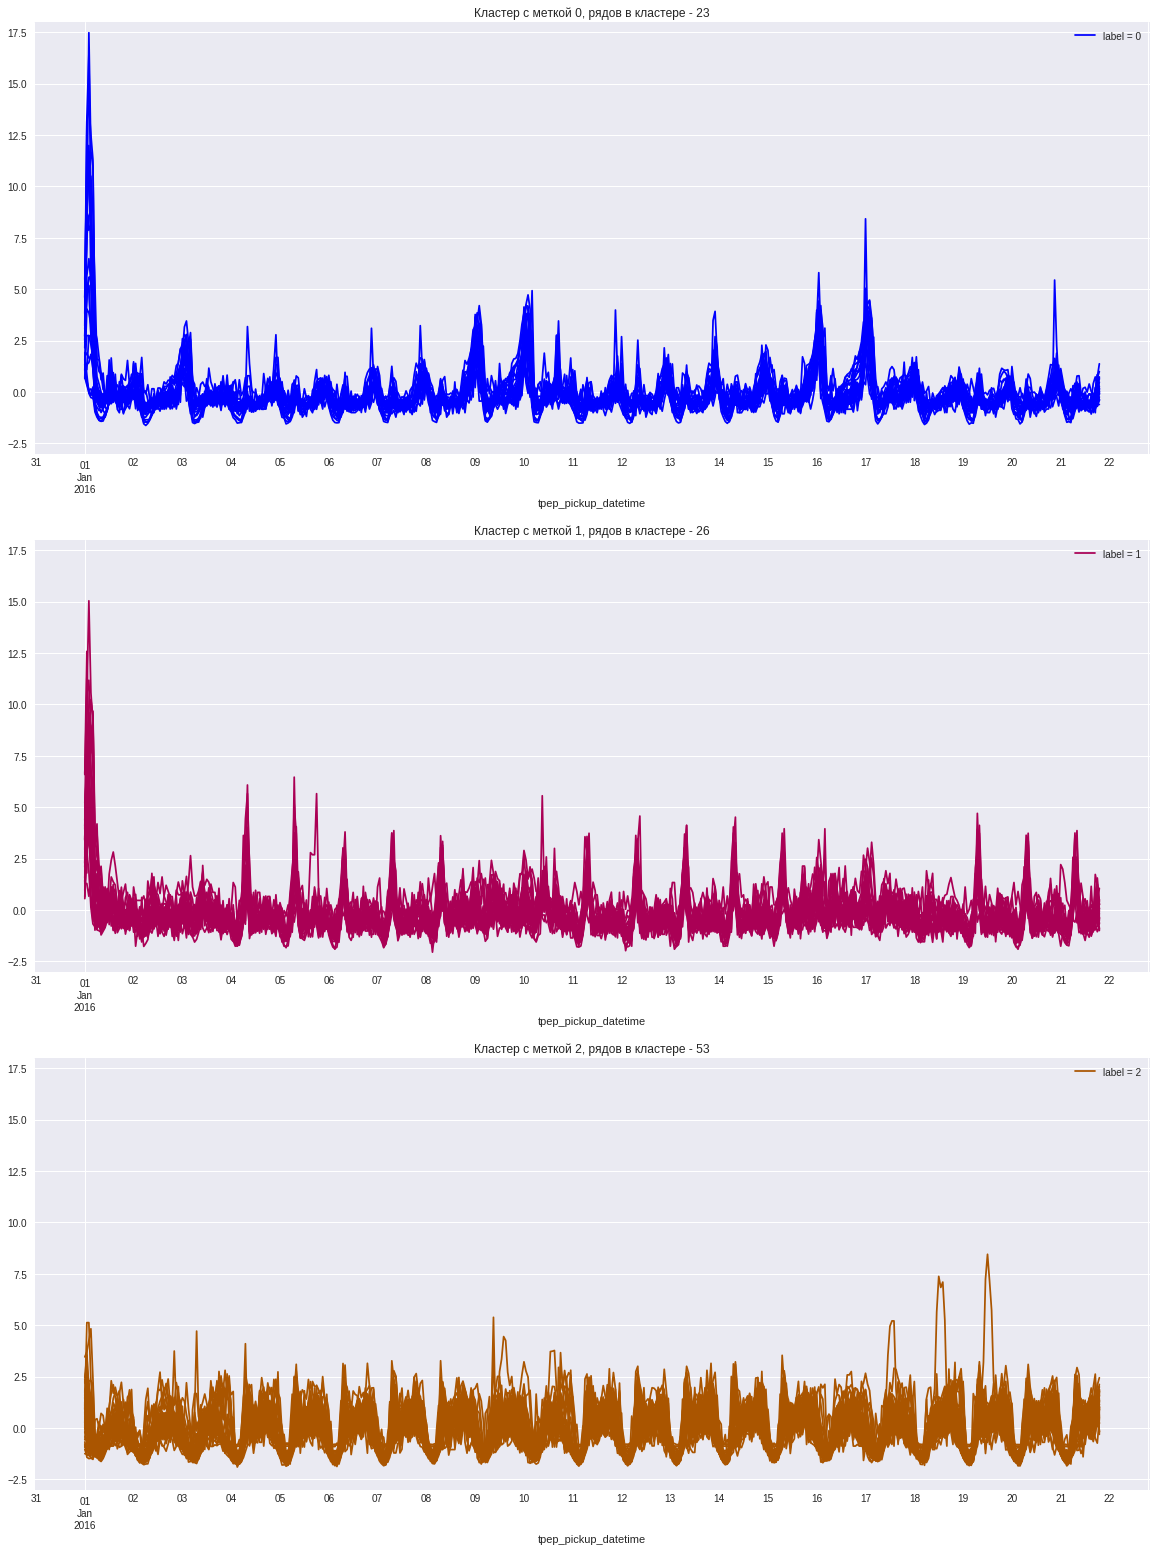

In [23]:
t_lag_for_show=500

clusterizer = cluster.KMeans(n_clusters=n, random_state=17)
clusterizer.fit(stand_data[selected_cells].T)

labels = clusterizer.labels_

fig, ax = plt.subplots(n, figsize=(20, n * 9))
for label in np.unique(labels):
    stand_data.iloc[:t_lag_for_show, labels == label].plot(c=cm.brg(label / n), ax=ax[label])
    ax[label].legend(['label = {}'.format(label)])
    ax[label].grid(True)
    y_min, y_max = (int(stand_data[selected_cells][:t_lag_for_show].values.min()) 
                    - 1, int(stand_data[selected_cells][:t_lag_for_show].values.max()) + 1)
    ax[label].set_ylim(y_min, y_max)
    ax[label].set_title('Кластер с меткой {}, рядов в кластере - {}'.format(label, (labels == label).sum()))
plt.show()

Посмотрим для наглядности отдельно на количество рядов в кластерах:

In [24]:
[(labels == label).sum() for label in np.unique(labels)]

[23, 26, 53]

In [0]:
''' вариант с двумя графиками в ряду '''
# n = 4

# t_lag_for_show=100

# clusterizer = cluster.KMeans(n_clusters=n, random_state=17)
# clusterizer.fit(stand_data.T)

# labels = clusterizer.labels_

# fig, ax = plt.subplots(ceil(n / 2), 2, figsize=(18, ceil(4.5 * n)))
# ax.resize(ceil(n / 2), 2) # иначе при n = 2 дает ошибку
# for label in np.unique(labels):
#     stand_data.iloc[:t_lag_for_show, labels == label].plot(c=cm.brg(label / n), ax=ax[label // 2, label % 2])
#     ax[label // 2, label % 2].legend(['label = {}'.format(label)])
#     ax[label // 2, label % 2].grid(True)
#     y_min, y_max = (int(stand_data[:t_lag_for_show].values.min()) - 1, int(stand_data[:t_lag_for_show].values.max()) + 1)
#     ax[label // 2, label % 2].set_ylim(y_min, y_max)
#     ax[label // 2, label % 2].set_title('Кластер временных рядов с меткой {}'.format(label))
# plt.show()

' вариант с двумя графиками в ряду '

### 4) Выбор ряда
В каждом кластере выберем наиболее типичный ряд (здесь это будет ряд, соответствующий центру кластера).

Найдем центр кластера и найдем наиболее близкий к нему ряд

In [25]:
typical_zones = []
for label in np.unique(labels):
    clust_data = stand_data.T.iloc[labels == label, :]
    clust_center = clust_data.mean().values
    min_dist = float('inf')
    for zone in clust_data.index:
        dist = np.linalg.norm(clust_center - clust_data.loc[zone].values)
        if dist < min_dist:
            min_dist = dist
            min_zone = zone
    typical_zones.append(min_zone)
typical_zones

['1326', '1387', '1234']

Посмотрим на "наиболее типичные" ряды:

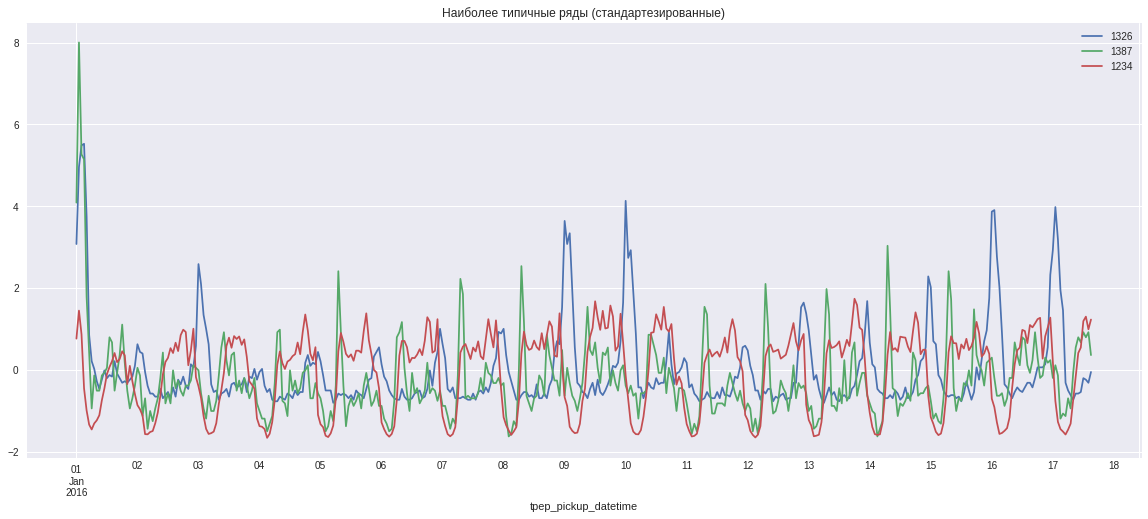

In [26]:
stand_data[typical_zones][:400].plot(figsize=(20, 8), grid=True)
plt.title('Наиболее типичные ряды (стандартезированные)');

### 5) Подбор оптимальной структуры моделей
Для выбранных географических зон подберем на **исходных рядах** оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров **p,d,q,P,D,Q** — так, как это делалось в прошлой части. Не будем использовать данные за последний имеющийся месяц — май и июнь 2016!

Создадим регрессионные признаки для учёта сезонностей и трендов

In [0]:
def add_regress_features(data):
    '''
    возвращает кортеж - данные с добавленными регрессионными фичами и список добавленных фич
    '''
    # недельная сезонность
    K = 5
    week_in_hours = 168 # неделя в часах
    for i in range(1, K + 1):
        data['weekly_seasonality_SIN_' + str(i)] = np.sin((np.arange(len(data)) + 1) * 2 * np.pi * i / week_in_hours)
        data['weekly_seasonality_COS_' + str(i)] = np.cos((np.arange(len(data)) + 1) * 2 * np.pi * i / week_in_hours)

    # уикэнды
    data['weekday'] = data.index.weekday
    data['weekend'] = data['weekday'].isin([5, 6]).astype(int)

    # день недели
    for i in range(7):
        data['dayofweek_{}'.format(i)] = data['weekday'].isin([i]).astype(int)

    # праздники США
    from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
    calendar = calendar()
    holidays = calendar.holidays(start=data.index.min(), end=data.index.max())
    data['holiday'] = data.index.isin(holidays).astype(int)

    # Список призднаков для регрессии
    feature_list = ['weekly_seasonality_' + SIN_or_COS + '_' + str(i) for i in range(1, K + 1) for SIN_or_COS in ['SIN', 'COS']]
    feature_list.extend(['weekend', 'holiday'])
    feature_list.extend(['dayofweek_{}'.format(i) for i in range(7)])
    
    return (data, feature_list)

In [0]:
data, feature_list = add_regress_features(data)

Сделаем регрессию целевого признака по выбранным стандартным ячейкам кластеров и посмотрим на остатки

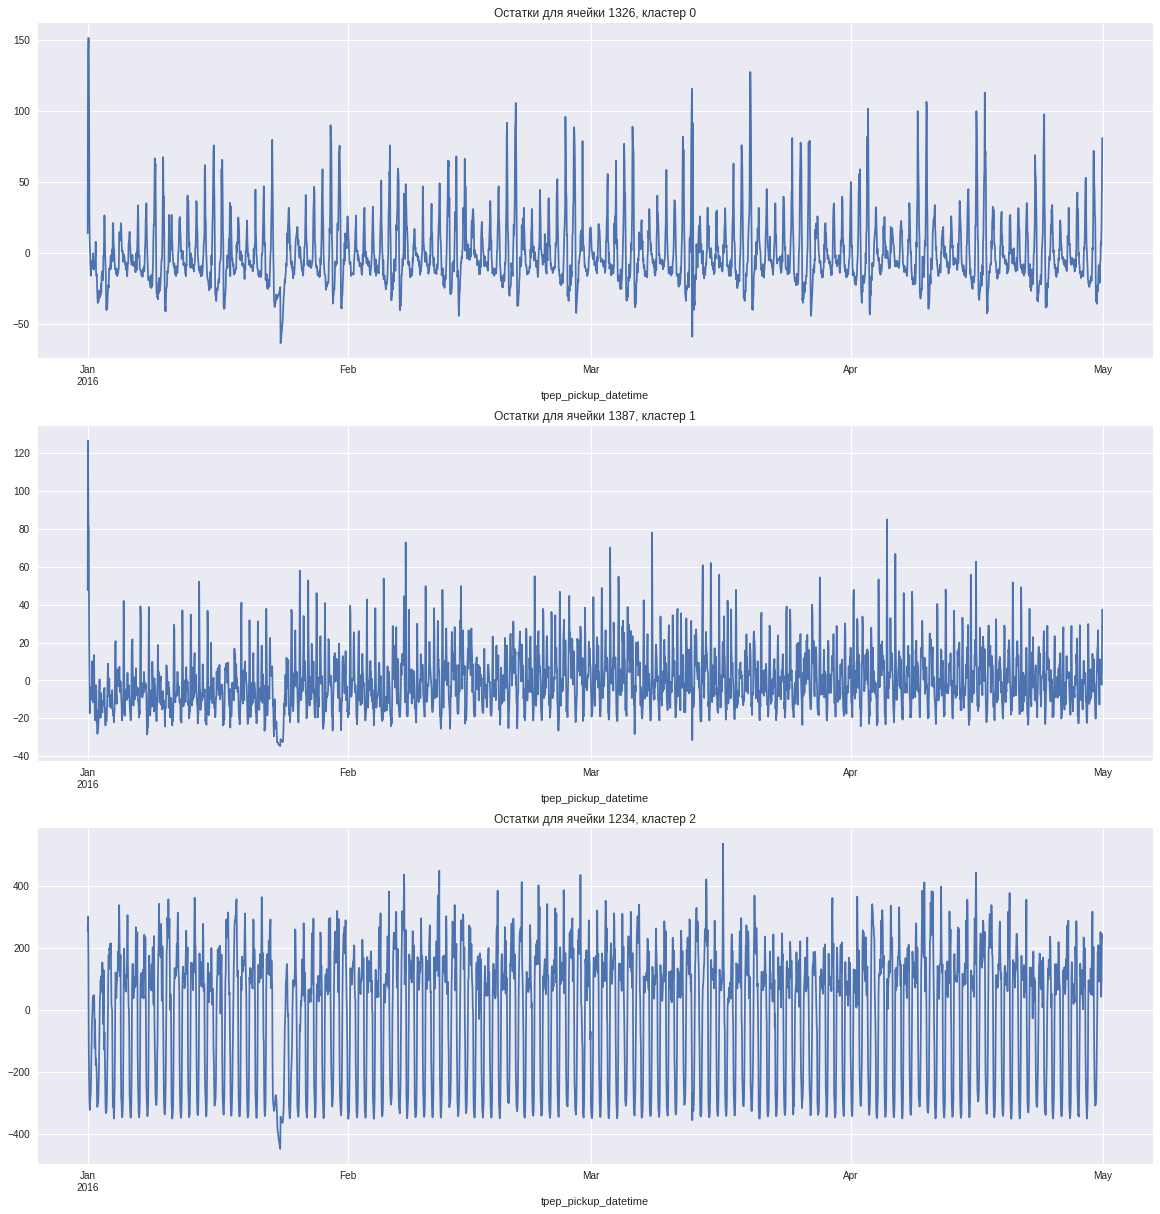

In [29]:
fig, ax = plt.subplots(len(typical_zones), figsize=(20, len(typical_zones) * 7))
for i, zone in enumerate(typical_zones):
    data['target'] = data[zone]
    ols_model = smf.ols('target ~ ' + '+'.join(feature_list), data=data)
    fitted = ols_model.fit(cov_type='HC1')
    fitted.resid.plot(ax=ax[i])
    ax[i].grid(True)
    ax[i].set_title('Остатки для ячейки {}, кластер {}'.format(zone, i))
plt.show()

Совсем избавиться от недельной сезонности пока не удалось (в идеале должна была остаться только суточная сезонность).  

Для Бокса-Кокса преобразования необходимости нет.

Подбор значения гиперпараметров ARIMA

Посмотрим на **STL-декомпозицию**

Ячейка - 1326, критерий Дики-Фуллера: p=1.364514e-08
Ячейка - 1387, критерий Дики-Фуллера: p=3.678335e-05
Ячейка - 1234, критерий Дики-Фуллера: p=1.767264e-07


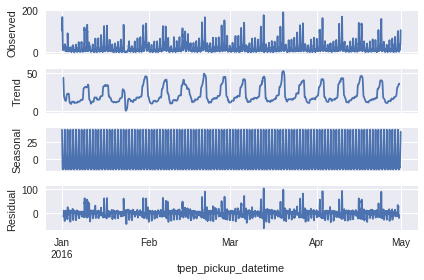

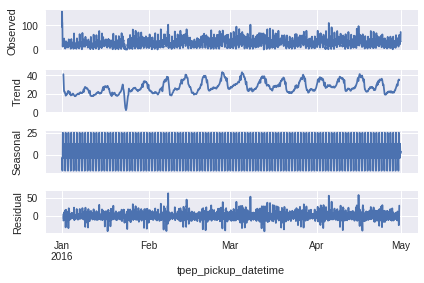

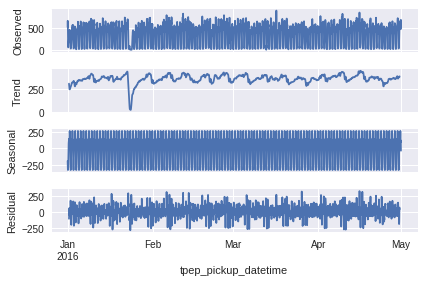

In [30]:
for i, zone in enumerate(typical_zones):
    sm.tsa.seasonal_decompose(data[zone]).plot()
    print("Ячейка - {}, критерий Дики-Фуллера: p={:e}".format(zone, sm.tsa.stattools.adfuller(stand_data[zone])[1]))

Видим тренды. Будем дифференцировать

Ячейка - 1326, критерий Дики-Фуллера: p=1.476032e-26
Ячейка - 1387, критерий Дики-Фуллера: p=1.293984e-26
Ячейка - 1234, критерий Дики-Фуллера: p=1.269552e-23


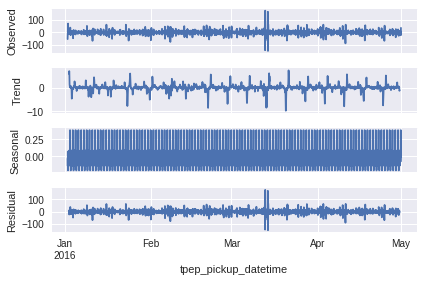

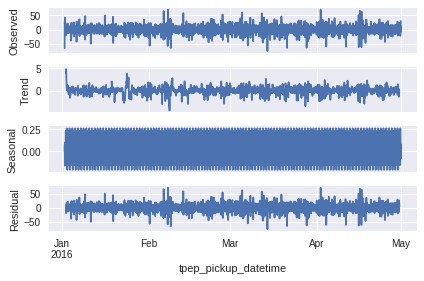

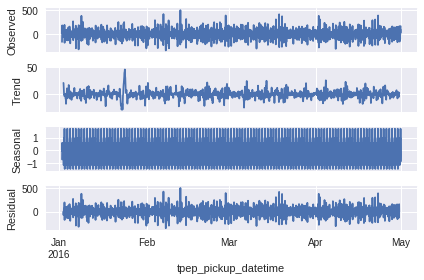

In [31]:
D = 1
S = 24
d = 1
lag = 1

for i, zone in enumerate(typical_zones):
    data[zone + '_diff'] = data[zone] - data[zone].shift(S)
    data[zone + '_diff1'] = data[zone + '_diff'] - data[zone + '_diff'].shift(lag)
    sm.tsa.seasonal_decompose(data[zone + '_diff1'][(S + lag):]).plot()
    print("Ячейка - {}, критерий Дики-Фуллера: p={:e}"
          .format(zone, sm.tsa.stattools.adfuller(data[zone + '_diff1'][(S + lag):])[1]))

#### p, q, P, Q

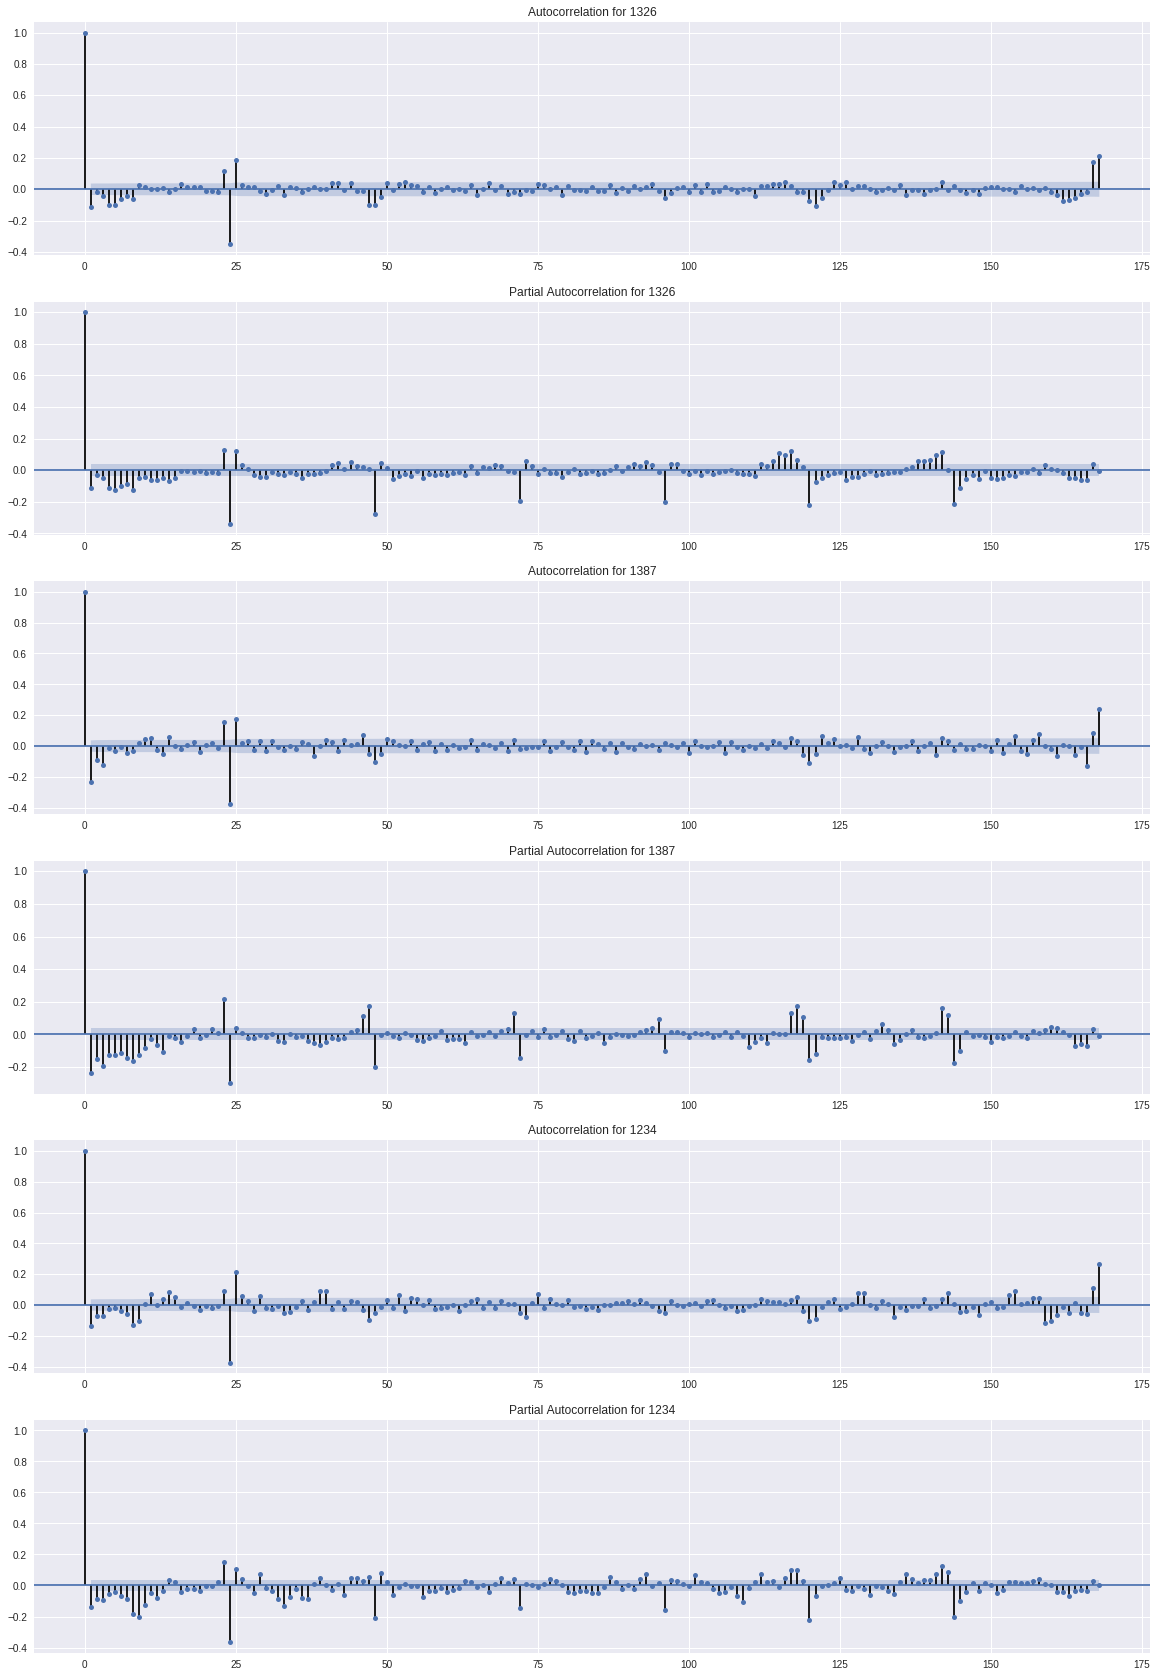

In [32]:
n = 2 * len(typical_zones)
fig, ax = plt.subplots(n, figsize=(20, n * 5))
for i, zone in enumerate(typical_zones):
    sm.graphics.tsa.plot_acf(data[zone + '_diff1'][(S + lag):].values.squeeze(), lags=168, 
                             title='Autocorrelation for ' + zone, ax=ax[2 * i])
    ax[2 * i].grid(True)
    sm.graphics.tsa.plot_pacf(data[zone + '_diff1'][(S + lag):].values.squeeze(), lags=168, 
                              title='Partial Autocorrelation for ' + zone, ax=ax[2 * i+1])
    ax[2 * i + 1].grid(True)
# plt.show()

Начальные приближения.   

По-хорошему, нужно взять (если усреднить по всем кластерам):

In [0]:
Q = 1
q = 1
P = 6
p = 9

Но ресурсы компа перебирать все это не позволяют. Поэтому для этой демонстрационной задачи возьмем по-минимуму:

In [0]:
Q = 1
q = 1
P = 1
p = 2

In [35]:
ps = range(0, p + 1)
qs = range(0, q + 1)
Ps = range(0, P + 1)
Qs = range(0, Q + 1)

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [36]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

24

In [0]:
#@title Default title text
%%time
warnings.filterwarnings('ignore')

results = {}
best_aic = {}
best_param = {}
best_model = {}

for i, zone in enumerate(typical_zones):
    
    results[zone] = []
    best_aic[zone] = float("inf")

    for param in tqdm(parameters_list):
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(endog=data[zone], 
                                            exog=data[feature_list], 
                                            order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], S)).fit()
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            print('wrong parameters for {} (ValueError):'.format(zone), param)
            continue
        except LinAlgError:
            print('wrong parameters for {} (LinAlgError):'.format(zone), param)
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic[zone]:
            best_model[zone] = model
            best_aic[zone] = aic
            best_param[zone] = param
        results[zone].append([param, model.aic])

    
warnings.filterwarnings('default')

In [0]:
for zone in typical_zones:
    result_table = pd.DataFrame(results[zone])
    result_table.columns = ['parameters', 'aic']
    print('типичная ячейка кластера -', zone, '\n',
        result_table.sort_values(by = 'aic', ascending=True).head(), '\n')

типичная ячейка кластера - 1326 
       parameters           aic
22  (2, 1, 1, 1)  21480.712391
20  (2, 1, 0, 1)  21515.575382
10  (1, 0, 1, 1)  21780.017024
6   (0, 1, 1, 1)  21782.474741
18  (2, 0, 1, 1)  21782.501607 

типичная ячейка кластера - 1387 
       parameters           aic
14  (1, 1, 1, 1)  21156.401849
12  (1, 1, 0, 1)  21216.801063
18  (2, 0, 1, 1)  21641.094709
6   (0, 1, 1, 1)  21649.918196
10  (1, 0, 1, 1)  21698.240652 

типичная ячейка кластера - 1234 
       parameters           aic
14  (1, 1, 1, 1)  31680.677973
12  (1, 1, 0, 1)  31778.901802
18  (2, 0, 1, 1)  32030.934686
6   (0, 1, 1, 1)  32038.063803
10  (1, 0, 1, 1)  32040.843405 



Сохраним / загрузим результаты обучения:

In [0]:
# with open(os.path.join(path_to_data, 'best_param.pkl'), 'wb') as best_param_pkl:
#     pickle.dump(best_param, best_param_pkl)

with open(os.path.join(path_to_data, 'best_param.pkl'), 'rb') as best_param_pkl:
    best_param = pickle.load(best_param_pkl)

Модели сохранить не удалось, только параметры.    
Поэтому сделаем блок расчета моделей по уже имеющимся лучшим параметрам (~15 мин.)

In [0]:
%%time
warnings.filterwarnings('ignore')

best_model = {}

for zone in tqdm_notebook(typical_zones):
    param = best_param[zone]

    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(endog=data[zone], 
                                        exog=data[feature_list], 
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], S)).fit()
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters for {} (ValueError):'.format(zone), param)
        continue
    except LinAlgError:
        print('wrong parameters for {} (LinAlgError):'.format(zone), param)
        continue
    #сохраняем посчитанную лучшую модель
    best_model[zone] = model
    
warnings.filterwarnings('default')

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))


Wall time: 14min 31s


### 6) Построение и анализ прогноза
Для каждой из R географических зон настроим на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 построим прогноз на 6 часов вперёд и посчитаем в ноутбуке ошибку прогноза по следующему функционалу:
$$Q_{may}=\frac{1}{R∗739∗6}\sum_{r=1}^{R}\sum_{T=2016.04.30\ 23:00}^{2016.05.31\ 17:00}\sum_{i=1}^{6}∣\hat{y}^r_{T|T+i}−y^r_{T+i}∣.  $$ 

Для контроля адекватности посчитаем и визуализируем 3-х дневный прогноз от тех данных, на которых строили модель

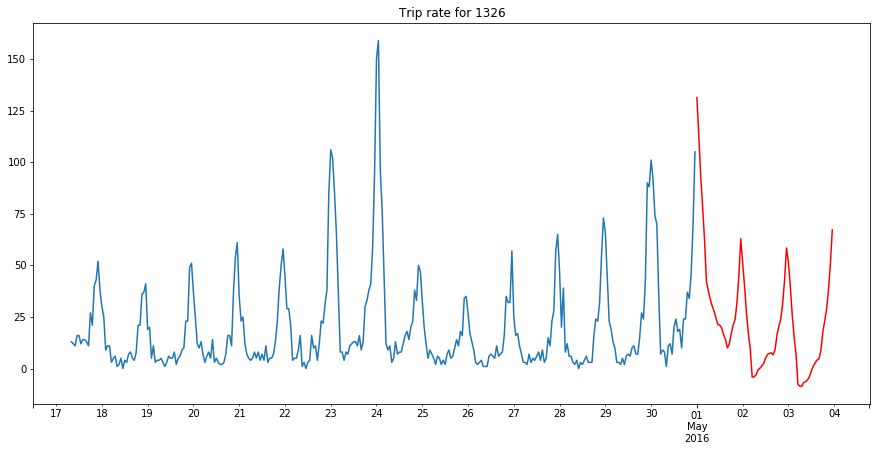

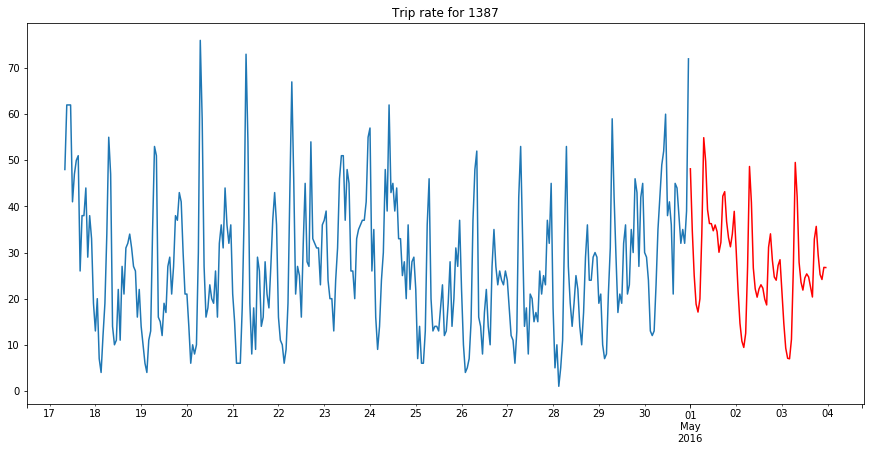

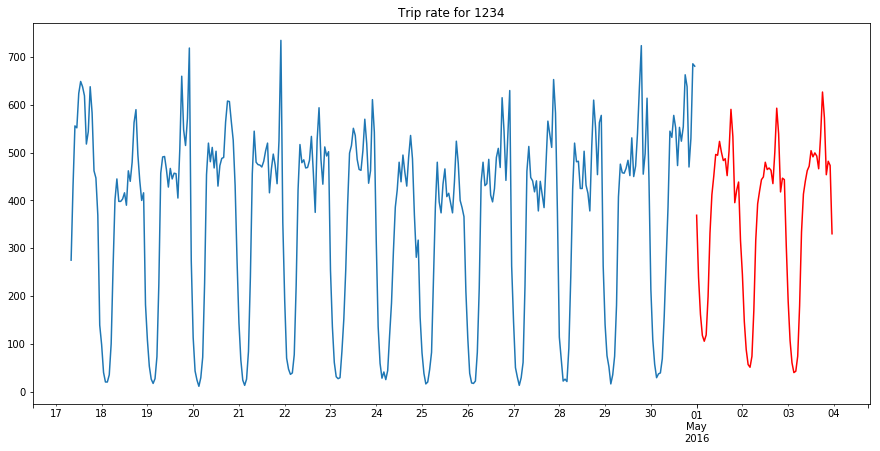

In [0]:
n = 3 * 24 # глубина прогнозирования, часов

for zone in typical_zones:
    data2 = data[[zone]]
#     конец истории
    date_end = pd.datetime.strftime(data.index[-1], '%Y-%m-%d %H:%M:%S')
#     список дат для прогноза
    date_list = [pd.datetime.strptime(date_end, '%Y-%m-%d %H:%M:%S') + relativedelta(hours=x) for x in range(1, n + 1)]
#     заготовка для ппрогноза
    future = pd.DataFrame(index=date_list, columns= data2.columns)

    # делаем exog-аргумент для прогноза (регрессионные признаки для прогноза)
    # sin & cos
    for i in range(1, K + 1):
        future['weekly_seasonality_SIN_' + str(i)] = np.sin(np.arange(len(data), len(data) + len(date_list)) 
                                                            * 2 * np.pi * i / week_in_hours)
        future['weekly_seasonality_COS_' + str(i)] = np.cos(np.arange(len(data), len(data) + len(date_list)) 
                                                            * 2 * np.pi * i / week_in_hours)

    # уикэнды
    future['weekday'] = future.index.weekday
    future['weekend'] = future['weekday'].isin([5, 6]).astype(int)

    # день недели
    for i in range(7):
        future['dayofweek_{}'.format(i)] = future['weekday'].isin([i]).astype(int)

    # праздники США
    # from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
    # calendar = calendar()
    holidays = calendar.holidays(start=future.index.min(), end=future.index.max())
    future['holiday'] = future.index.isin(holidays).astype(int)

    data2 = pd.concat([data2, future])

    start = len(data)
    end = start + (n - 1)

    exog_future = future[feature_list][-len(date_list):]

    data2['forecast'] = best_model[zone].predict(start=start, end=end, exog=exog_future)

#     визуализация прогноза (для контроля)
    plt.figure(figsize=(15,7))
    data2[zone][-400:].plot()
    data2['forecast'].plot(color='r')
    plt.title('Trip rate for {}'.format(zone))
    plt.show()

Видим - все более-менее адекватно.

Далее.   
Имеем следующее.   
Одна модель на моем железе считается около 5 минут. Если настраивать отдельно модель для каждой из 102 зон, это будет $102 * 5 / 60$ ~ около **9 часов**. Многовато.    
Поэтому поступим следующим образом.    
Будем считать, что внутри каждого кластера формы рядов примерно одинаковы и рассчитаем одну модель для каждого кластера. А для того чтобы учесть разный масштаб рядов, обучим модели на **стандартизированных** типичных рядах, а предсказывать при этом будем также стандартизированные ряды (на соответствующих стандартизированных рядах), после чего сделаем **обратное преобразование** в реальный ряд.    
Надеюсь, что при таком подходе качество предсказания останется приемлемым (хотя, правильнее, это тоже надо тестировать, но будем считать, что это не входит в рамки этой задачи).

Параметры стандартизации (ранее мы их не сохраняли):

In [0]:
data_mean = data[selected_cells].mean()
data_std = data[selected_cells].std()

Рассчитаем модели по каждому кластеру на **стандартизированных** данных **до апреля включительно** (сейчас данные загружены с учетом этого):

In [0]:
%%time
warnings.filterwarnings('ignore')

best_stand_model = {}

for zone in tqdm_notebook(typical_zones):
    param = best_param[zone]

    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(endog=stand_data[zone], 
                                        exog=data[feature_list], 
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], S)).fit()
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters for {} (ValueError):'.format(zone), param)
        continue
    except LinAlgError:
        print('wrong parameters for {} (LinAlgError):'.format(zone), param)
        continue
    #сохраняем посчитанную лучшую модель
    best_stand_model[zone] = model
    
warnings.filterwarnings('default')

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))



Wall time: 15min 3s


Загрузим и подготовим данные, **включая май и июнь**. Отфильтровывать май и июнь будем в процессе расчета моделей и  предсказания, в том числе используя пареметр `dynamic=True` в методе `predict()`.

In [0]:
data_full = pd.DataFrame()
for path_to_file in tqdm_notebook(glob(os.path.join(path_to_data, 'aggdata_*.csv'))):
    aggdata = read_aggdata(os.path.basename(path_to_file))
    data_full = pd.concat([data_full, aggdata[selected_cells]])

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

стандартизируем, используя **те же параметры стандартизации**, которые были выше

In [0]:
stand_data_full = (data_full[selected_cells] - data_mean) / data_std

Поскольку добавился май и июнь, создадим по-новому регрессионные признаки

In [0]:
stand_data_full, feature_list = add_regress_features(stand_data_full)

Для прогнозирования будем использовать конструкцию, которая для предсказаний учитывает **только разрешенную** часть данных,  используя пареметр `dynamic=True` в методе `predict()`..    
Сразу будем считать и накапливать функционал **Q_may**.

In [0]:
# ряд концов историй 2016.04.30 23:00 до 2016.05.31 17:00
start_range = '2016-04-30 23:00:00'
end_range = '2016-05-31 17:00:00'
time_range = pd.date_range(start_range, end_range, freq='H')
len(time_range)

739

Для ускорения времени расчетов сделаем **два приема**:   
1. Параметры (коэффициенты) моделей у нас уже рассчитаны на полных данных. Они передаются в модель через метод `.filter()`. Поэтому временной ряд, передаваемый в модель и по которому будет рассчитываться прогноз, сокращаем до минимума. С учетом сезонного (S=24) дифференцирования и единичного сезонного лага  и p=2 это будет примерно $24+24+2 = 50$. Возьмем с запасом - 60.   
2. Выберем случайным образом часть ячеек для расчета и часть временного ряда концов историй. Соответствующим образом скорректируем нормировку функционала.

In [0]:
selected_cells_part = random.sample(selected_cells, int(len(selected_cells) / 6)) # часть от ячеек
# selected_cells_part = [random.sample(list(np.array(selected_cells)[labels == label]), 1)[0] 
#                        for label in np.unique(labels)] # часть от ячеек, другой вариант

time_range_part = random.sample(list(time_range), int(len(time_range) / 4)) # часть от временного ряда

In [0]:
%%time
Q_may = 0
R_part = len(selected_cells_part)
for cell in tqdm_notebook(selected_cells_part):
    for time in time_range_part:
        n_kluster = labels[selected_cells.index(cell)] # номер кластера
        zone = typical_zones[n_kluster] # типичная для кластера ячейка
        param = best_param[zone]
        
        model_fitted = sm.tsa.statespace.SARIMAX(endog=stand_data_full[cell]
                                                                 [time - relativedelta(hours=60):time + relativedelta(hours=7)], 
                                                exog=stand_data_full[feature_list]
                                                                 [time - relativedelta(hours=60):time + relativedelta(hours=7)], 
                                                order=(param[0], d, param[1]), 
                                                seasonal_order=(param[2], D, param[3], S)).filter(best_stand_model[zone].params)

        predicted_data = model_fitted.predict(time + relativedelta(hours=1), time + relativedelta(hours=6), dynamic=True)
        # обратное преобразование из стандартного
        predicted_data = predicted_data * data_std[cell] + data_mean[cell]
        Q_may += (predicted_data - data_full.loc[predicted_data.index, zone]).abs().sum()
# нормируем
Q_may /= R_part * len(time_range_part) * 6
print('Q_may =', Q_may)

HBox(children=(IntProgress(value=0, max=17), HTML(value='')))



Q_may = 169.89605827448773
Wall time: 17min 10s


Для комплекта - код для расчета функционала $Q_{may}$ на полных данных:

```python
%%time
Q_may = 0
R = len(selected_cells)
for cell in tqdm_notebook(selected_cells):
    for time in time_range:
        n_kluster = labels[selected_cells.index(cell)] # номер кластера
        zone = typical_zones[n_kluster] # типичная для кластера ячейка
        param = best_param[zone]
        
        model_fitted = sm.tsa.statespace.SARIMAX(endog=stand_data_full[cell]
                                                         [time - relativedelta(hours=60):time + relativedelta(hours=7)], 
                                                exog=stand_data_full[feature_list]
                                                         [time - relativedelta(hours=60):time + relativedelta(hours=7)], 
                                                order=(param[0], d, param[1]), 
                                                seasonal_order=(param[2], D, param[3], S))
                                                         .filter(best_stand_model[zone].params)

        predicted_data = model_fitted.predict(time + relativedelta(hours=1), time + relativedelta(hours=6), dynamic=True)
        # обратное преобразование из стандартного
        predicted_data = predicted_data * data_std[cell] + data_mean[cell]
        Q_may += (predicted_data - data_full.loc[predicted_data.index, zone]).abs().sum()
# нормируем
Q_may /= R * len(time_range) * 6
print('Q_may =', Q_may)
```

### 7) Прогноз на май для $kaggle$
Для каждой из $R$ географических зон настроим на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 построим прогноз на 6 часов вперёд и запишем все прогнозы в файл в формате $id,y$, где столбец $id$ состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец $y$ — наш прогноз.

Пересчитаем параметры модели с данными **по май включительно**:

In [0]:
%%time
warnings.filterwarnings('ignore')

best_stand_model = {}

for zone in tqdm_notebook(typical_zones):
    param = best_param[zone]

    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(endog=stand_data[zone].loc[:'2016-05-31'], 
                                        exog=data[feature_list].loc[:'2016-05-31'], 
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], S)).fit()
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters for {} (ValueError):'.format(zone), param)
        continue
    except LinAlgError:
        print('wrong parameters for {} (LinAlgError):'.format(zone), param)
        continue
    #сохраняем посчитанную лучшую модель
    best_stand_model[zone] = model
    
warnings.filterwarnings('default')

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))



Wall time: 15min 3s


Расчитывать прогнозы будем с использованием приемов, как это делали в предыдущем пункте

In [0]:
# ряд концов историй 2016.04.30 23:00 до 2016.05.31 17:00
start_range = '2016-05-31 23:00:00'
end_range = '2016-06-30 17:00:00'
time_range = pd.date_range(start_range, end_range, freq='H')
len(time_range)

715

In [0]:
%%time
forecast_juny = []
R = len(selected_cells)
for cell in tqdm_notebook(selected_cells):
    for time in time_range:
        n_kluster = labels[selected_cells.index(cell)] # номер кластера
        zone = typical_zones[n_kluster] # типичная для кластера ячейка
        param = best_param[zone]
        
        model_fitted = sm.tsa.statespace.SARIMAX(endog=stand_data_full[cell]
                                                                 [time - relativedelta(hours=60):time + relativedelta(hours=7)], 
                                                exog=stand_data_full[feature_list]
                                                                 [time - relativedelta(hours=60):time + relativedelta(hours=7)], 
                                                order=(param[0], d, param[1]), 
                                                seasonal_order=(param[2], D, param[3], S)).filter(best_stand_model[zone].params)

        predicted_data = model_fitted.predict(time + relativedelta(hours=1), time + relativedelta(hours=6), dynamic=True)
        # обратное преобразование из стандартного
        predicted_data = predicted_data * data_std[cell] + data_mean[cell]
        forecast_juny.append((time, predicted_data))

print('len(forecast_juny):', len(forecast_juny))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))



len(forecast_juny): 72930
Wall time: 6h 25min 13s


Сохраним пока результаты расчетов:

In [0]:
# with open(os.path.join(path_to_data, 'forecast_juny.pkl'), 'wb') as file_pkl:
#     pickle.dump(forecast_juny, file_pkl)

with open(os.path.join(path_to_data, 'forecast_juny.pkl'), 'rb') as file_pkl:
    forecast_juny = pickle.load(file_pkl)

Сформируем сабмишн по нужному формату, добавив ячейку:

In [0]:
%%time
predict_list = []
for i, cell in tqdm_notebook(enumerate(selected_cells), total=len(selected_cells)):
    for item in forecast_juny[715 * i:715 * (i + 1)]:
        predict_list.extend([('{}_{}_{}_{}'.format(cell, item[0].strftime('%Y-%m-%d'), item[0].hour, j + 1), 
                              max(0, item[1][j])) for j in range(6)]) # отрицательное предсказание заменяем на 0

predict_df = pd.DataFrame(data=list(map(lambda x: int(x[1]), predict_list)), 
                          index=list(map(lambda x: x[0], predict_list)), columns=['y'])
predict_df.index.name = 'id'

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))


Wall time: 19.1 s


#### Проверим

In [0]:
len(predict_df)

437580

In [0]:
predict_df.head(10)

,y
id,
1075_2016-05-31_23_1,1
1075_2016-05-31_23_2,0
1075_2016-05-31_23_3,0
1075_2016-05-31_23_4,0
1075_2016-05-31_23_5,0
1075_2016-05-31_23_6,0
1075_2016-06-01_0_1,8
1075_2016-06-01_0_2,0
1075_2016-06-01_0_3,0


Вроде все ОК, сохраним и отправим на **kaggle**:

In [0]:
predict_df.to_csv((os.path.join(path_to_data, 'predict_df_tokaggle.csv')))

На **kaggle** все прошло, вот [ссылка на leaderboard](https://www.kaggle.com/c/yellowtaxi/leaderboard) и скриншот:
![mountains](img/kaggle_week4.png "Пейзаж с горами")